# Book Babies

## Embedding Calculations

### EEK 2024-10-21

In [1]:
# ! pip install tqdm boto3 requests regex sentencepiece sacremoses
# ! git clone https://github.com/FlagOpen/FlagEmbedding.git
# ! cd FlagEmbedding
# ! pip install -e .
# ! poetry add FlagEmbedding
# ! poetry add peft

In [617]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
import csv
from tqdm import tqdm

from typing import Dict, Text
import re
import json
import io
from IPython.display import Image

# Import necessary modules
import transformers
from FlagEmbedding import BGEM3FlagModel

# Import metrics for ranking 
from sklearn.metrics import mutual_info_score

* Found a spotify dataset on huggingface and I think that's the best kind of V0 - all of the things are well controlled for...
* And song babies is also a fun project :)
* df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

* But for generating embeddings for large text, we've got:
* https://huggingface.co/BAAI/bge-m3


## Generate embeddings for large text using the BGE-M3 model from huggingface

In [ ]:
model = BGEM3FlagModel('BAAI/bge-m3',  
                       use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
# test 

sentences_1 = ["What is BGE M3?", "Defination of BM25"]
sentences_2 = ["BGE M3 is an embedding model supporting dense retrieval, lexical matching and multi-vector interaction.", 
               "BM25 is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document"]

embeddings_1 = model.encode(sentences_1, 
                            batch_size=12, 
                            max_length=8192, # If you don't need such a long length, you can set a smaller value to speed up the encoding process.
                            )['dense_vecs']
embeddings_2 = model.encode(sentences_2)['dense_vecs']

In [13]:
# how well does it perform? 
similarity = embeddings_1 @ embeddings_2.T
print(similarity)
# [[0.6265, 0.3477], [0.3499, 0.678 ]]

[[0.626  0.3477]
 [0.3499 0.678 ]]


In [241]:
df_raw = pd.read_csv('data/data_cleaned.csv').drop(columns=['Summary_length', 'Unnamed: 0'])

In [242]:
df_raw.shape

(3196, 11)

In [19]:
%%time 
df = df_raw.copy()
df['embed1'] = [model.encode(a, batch_size=12, max_length=8192)['dense_vecs'] for a in df.Summary]

CPU times: user 10min 57s, sys: 6min 46s, total: 17min 43s
Wall time: 13h 1min 41s


In [20]:
print('all done')

all done


In [112]:
df.head(5)

,BookTitle,Author,Summary,genre_list,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works,embed1
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...","['Roman à clef', 'Satire', ""Children's literat...",1956.0,8.281910,1.721726,120.0,8.565043,344.0,8,"[-0.00864, 0.03973, -0.02974, -0.01372, -0.030..."
1,The Plague,Albert Camus,The text of The Plague is divided into five p...,"['Existentialism', 'Fiction', 'Absurdist ficti...",1972.0,8.111111,1.166667,9.0,8.039720,107.0,7,"[0.05157, 0.04187, -0.03, -0.02156, 0.01306, -..."
2,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...","['War novel', 'Roman à clef']",1990.0,8.531250,1.413857,32.0,8.391304,46.0,4,"[0.01214, 0.005836, -0.0624, -0.0155, -0.01211..."
3,Crash,J. G. Ballard,The story is told through the eyes of narrato...,"['Speculative fiction', 'Fiction', 'Novel']",1996.0,6.000000,NaN,1.0,7.431818,11.0,17,"[-0.013916, -0.02834, -0.011765, -0.01927, 0.0..."
4,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,"['Science Fiction', 'Speculative fiction', ""Ch...",1977.0,8.875000,2.121320,5.0,8.208907,353.0,20,"[0.02283, 0.002647, -0.03833, -0.0379, -0.0370..."


In [26]:
df['embed1'][0].shape

(1024,)

## Try a test pairing manually

In [245]:
# try crossing Parent 1 and Parent 2

embed_p1 = list(df['embed1'][df.BookTitle=='Timequake'])
embed_p2 = list(df['embed1'][df.BookTitle=='The Wind in the Willows'])

test_embed_mean = np.mean([embed_p1, embed_p2], axis=0)

test_embed_mean.shape

(1, 1024)

In [246]:
embed_p1[0:10]

[array([ 0.00154,  0.02184, -0.01671, ..., -0.05133, -0.03018, -0.0573 ],
       dtype=float16)]

In [247]:
embed_p2[0:10]

[array([ 0.04276 ,  0.03992 , -0.05338 , ..., -0.002136, -0.02936 ,
        -0.01717 ], dtype=float16)]

In [248]:
test_embed_mean

array([[ 0.02214,  0.03088, -0.03503, ..., -0.02673, -0.02977, -0.03723]],
      dtype=float16)

In [249]:
np.dot(embed_p1, np.asarray(embed_p2).T)

array([[0.5044]], dtype=float16)

In [250]:
df_test = df.copy()

In [251]:
df_test['cosine_similarity'] = df_test['embed1'].apply(lambda x: np.dot(x, test_embed_mean.T)[0])

In [253]:
df_test[df_test.num_ratings > 1.0].sort_values(by='cosine_similarity', ascending=False).head(10)

,BookTitle,Author,Summary,genre_list,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works,embed1,cosine_similarity
464,Timequake,Kurt Vonnegut,Vonnegut uses the premise of a timequake (or ...,"['Autobiographical novel', 'Time travel', 'Spe...",1997.0,7.459091,1.708786,32.0,8.067276,374.0,15,"[0.00154, 0.02184, -0.01671, 0.0084, -0.02313,...",0.752441
71,The Wind in the Willows,Kenneth Grahame,"At the start of the book, it is spring time: ...","[""Children's literature"", 'Fiction', 'Novel']",1980.0,8.051020,0.959388,18.0,8.305599,39.0,1,"[0.04276, 0.03992, -0.05338, 0.00727, -0.00520...",0.752441
844,Dandelion Wine,Ray Bradbury,Chapter 1 — Spending the night in the cupola ...,"['Science Fiction', 'Novel', 'Speculative fict...",1976.0,8.187500,1.258306,7.0,7.920468,244.0,9,"[-0.014595, 0.02852, -0.0353, -0.02394, -0.000...",0.608887
1236,Tales of a Fourth Grade Nothing,Judy Blume,The novel is a first person account of a nine...,"[""Children's literature"", 'Fiction']",1972.0,8.500000,0.707107,9.0,7.350943,550.0,19,"[-0.00927, 0.02141, -0.01071, -0.00859, -0.006...",0.593750
428,On the Road,Jack Kerouac,The two main characters of the book are the n...,"['Roman à clef', 'Novel', 'Fiction']",1981.0,8.466472,1.472710,58.0,7.618287,207.0,3,"[-0.04684, 0.00585, -0.05347, -0.00644, 0.0074...",0.588867
486,Invisible Man,Ralph Ellison,"In the beginning, the narrator lives in a sma...","['Science Fiction', ""Children's literature"", '...",1972.0,8.586264,1.364139,39.0,8.410093,46.0,2,"[-0.01222, 0.05914, -0.007042, 0.01755, -0.016...",0.587891
983,Ghostwritten,David Mitchell,"This details the actions of Quasar, a member ...",['Novel'],2000.0,7.857143,1.214986,7.0,8.166667,12.0,3,"[-0.01278, -0.02429, -0.0451, 0.0004408, -0.00...",0.586914
387,Breakfast of Champions,Kurt Vonnegut,"Kilgore Trout is a widely published, but othe...","['Science Fiction', 'Speculative fiction', 'Fi...",1991.0,7.628882,1.877020,37.0,8.067276,374.0,15,"[-0.005665, 0.02951, 0.0335, 0.006565, -0.0185...",0.586426
2275,Ghost Story,Peter Straub,The novel opens with a man named Donald Wande...,"['Speculative fiction', 'Horror', 'Fiction']",1979.0,7.583333,1.653205,13.0,6.973515,142.0,7,"[-0.0002449, -0.003752, -0.00467, -0.01805, 0....",0.586426
45,Tunnel in the Sky,Robert A. Heinlein,A Malthusian catastrophe on Earth has been av...,"['Science Fiction', 'Speculative fiction', ""Ch...",1987.0,7.600000,0.547723,5.0,8.123401,362.0,34,"[0.001365, 0.02235, -0.01874, -0.00605, -0.035...",0.585938


<Axes: xlabel='cosine_similarity', ylabel='Count'>

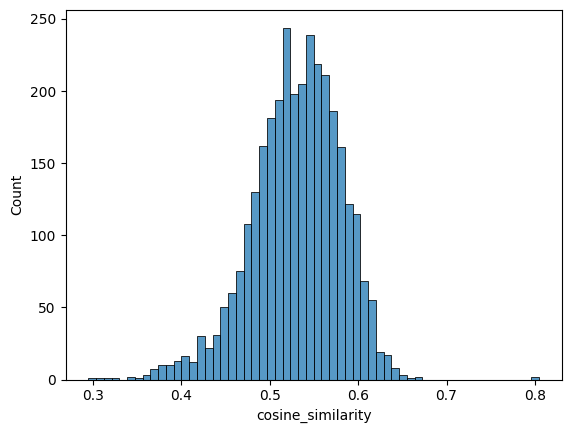

In [107]:
sns.histplot(data=df_test, x='cosine_similarity')

## Cosine similarity is great and a go-to but let's just check to see if other distance metrics might be useful

In [121]:
df_test['l2_distance'] = df_test['embed1'].apply(lambda x: np.linalg.norm(x - test_embed_mean[0]))  # euclidean distance
df_test['l1_distance'] = df_test['embed1'].apply(lambda x: np.linalg.norm(x - test_embed_mean[0], 1)) # manhattan distance

<Axes: xlabel='cosine_similarity', ylabel='l1_distance'>

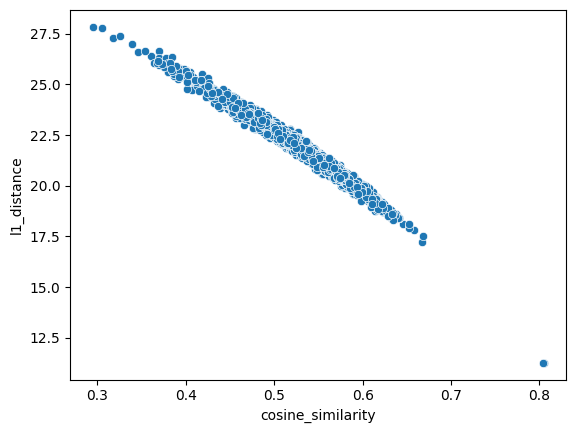

In [122]:
sns.scatterplot(data=df_test, x='cosine_similarity', y='l1_distance')

<Axes: xlabel='l1_distance', ylabel='Count'>

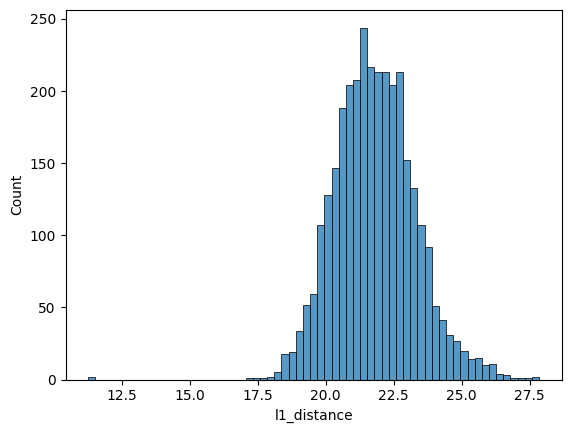

In [123]:
sns.histplot(data=df_test, x='l1_distance')

# Let's visualize this in tensorboard!

In [160]:
df_test['embed_tsv'] = [''.join(list(str(df_test['embed1'][i]))) for i in range(len(df_test))]

In [ ]:
# Tensorboard uses tsv files which are just tab separated rather than comma separated values

def write_tsv_iteratively(filename, data):
    """
    Writes data to a TSV file iteratively, line by line.

    Args:
        filename: The name of the TSV file to create.
        data: An iterable of lists or tuples representing rows of data.
    """

    with open(filename, 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t')

        for row in data:
            writer.writerow(row)
  

In [ ]:
write_tsv_iteratively("raw_embeddings.tsv", df_test['embed1'])

In [137]:
df_test['BookTitle'].to_csv('titles.tsv', sep='\t')

In [167]:
df_embeddings = pd.read_csv('raw_embeddings.tsv', sep='\t', header=None)

## Is PCA worth pursuing? (tldr: no)

Can PCA dimensionality reduction give us as good or better performance?

In [168]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.008640,0.039730,-0.029740,-0.01372,-0.030470,-0.037960,0.001379,0.017610,-0.010925,-0.003704,...,0.02159,0.023100,0.050380,0.03174,0.003107,0.014160,0.035950,0.008354,-0.041560,-0.016270
1,0.051570,0.041870,-0.030000,-0.02156,0.013060,-0.053200,-0.025040,0.002455,0.012470,0.033230,...,0.00903,0.009030,0.027340,0.03062,-0.023030,-0.002676,-0.010180,-0.012230,-0.020110,-0.023540
2,0.012140,0.005836,-0.062400,-0.01550,-0.012115,-0.016270,0.079400,-0.011570,0.023210,0.042570,...,-0.00869,0.044460,0.012505,0.03665,-0.032560,-0.008870,-0.007626,0.017670,-0.019360,0.011140
3,-0.013916,-0.028340,-0.011765,-0.01927,0.007740,0.006165,0.004050,-0.022100,0.010090,0.009544,...,-0.01339,0.048580,0.028610,0.04373,-0.029980,-0.008170,-0.026800,0.021300,0.004368,0.016070
4,0.022830,0.002647,-0.038330,-0.03790,-0.037080,-0.023040,-0.000899,0.009480,0.001187,0.026690,...,-0.00934,0.001112,0.048770,0.01526,-0.002321,-0.019500,-0.000202,0.033400,-0.011180,0.011086


In [169]:
from sklearn.decomposition import PCA

In [235]:
# First it's useful to see what the maximal PCA scree plot would look like, so that is shown below and an elbow is chosen

In [189]:
pca_test = PCA(n_components=1024)
pca_test.fit(df_embeddings)

PCA(n_components=1024)

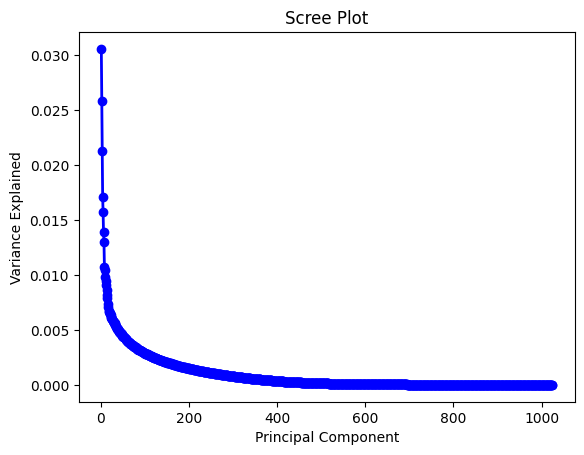

In [190]:
PC_values = np.arange(pca_test.n_components_) + 1
plt.plot(PC_values, pca_test.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [191]:
pca_test.explained_variance_ratio_

array([3.05357598e-02, 2.57686354e-02, 2.12823669e-02, ...,
       2.09336162e-06, 1.94795855e-06, 1.53575407e-09])

In [236]:
sum(pca_test.explained_variance_ratio_[0:199]) # how much variance is explained using the first 200 components?
# we are going to call this reasonable, we'll call the elbow 200.  I like numbers around 80%

0.7890199861472981

In [238]:

# and now we run it again for the number of components we actually want, 
# and do the transformation which reduces the size of each vector 
# from 1024 to 200, a roughly 80% savings for about a 20% loss in fidelity


In [194]:
pca = PCA(n_components=200)

In [199]:
df_embeddings_pca = pca.fit_transform(df_embeddings)

In [196]:
df_embeddings_pca.shape

(3196, 200)

### View this in tensorboard

In [200]:
write_tsv_iteratively("pca_embeddings.tsv", df_embeddings_pca)

In [ ]:
# Now let's also have some metadata to help us in the visualization

In [231]:
df_meta = df[['BookTitle', 'Author', 'genre_list', 'year_published', 'avg_rating', 'num_ratings', 'num_works']]
df_meta.head()

,BookTitle,Author,genre_list,year_published,avg_rating,num_ratings,num_works
0,Animal Farm,George Orwell,"['Roman à clef', 'Satire', ""Children's literat...",1956.0,8.281910,120.0,8
1,The Plague,Albert Camus,"['Existentialism', 'Fiction', 'Absurdist ficti...",1972.0,8.111111,9.0,7
2,All Quiet on the Western Front,Erich Maria Remarque,"['War novel', 'Roman à clef']",1990.0,8.531250,32.0,4
3,Crash,J. G. Ballard,"['Speculative fiction', 'Fiction', 'Novel']",1996.0,6.000000,1.0,17
4,Children of Dune,Frank Herbert,"['Science Fiction', 'Speculative fiction', ""Ch...",1977.0,8.875000,5.0,20


In [234]:
df_meta.to_csv('df_meta.tsv', sep='\t', index=False)

In [369]:
df['embed_pca'] = [np.array(df_pca[i]) for i in range(len(df_pca))] 

In [372]:
df.drop(['combined', 'Summary'], axis=1, inplace=True)

# Add in the Genetic Pairing 

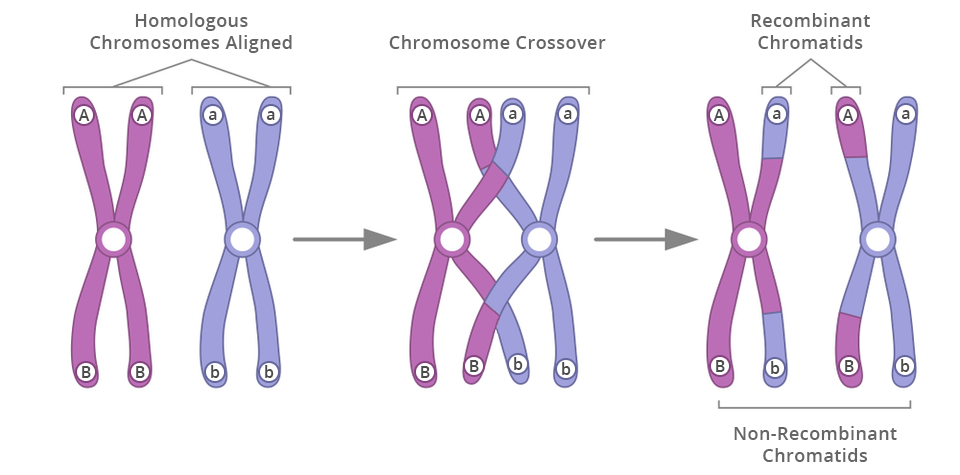

In [621]:
# Let's try some new genetic pairings the motivating concept is chromosome recombination

Image(filename = "recombinant chromosomes.png")

In [619]:
# inputs - the parent book titles, the column name of the embedding, the method, and if the top N results are shown.
# granularity will be added later.

def genetic_pairing(df, 
                    parent1_title = 'Timequake', 
                    parent2_title ='The Wind in the Willows' , 
                    embedding_colname = 'embeddings', 
                    similarity_colname = 'cosine_similarity',
                    method='mean', 
                    N=5, 
                    granularity=10,
                    drop_parents = True):

    df_temp = df.copy()
    assert ((method == 'genetic' and granularity != None) or method != 'genetic')

    parent1_embeddings = df_temp[embedding_colname][df_temp.BookTitle==parent1_title].reset_index(drop=True).loc[0]
    parent2_embeddings = df_temp[embedding_colname][df_temp.BookTitle==parent2_title].reset_index(drop=True).loc[0]
    
    
    if method == 'mean':
        baby_embeddings = np.mean([parent1_embeddings, parent2_embeddings], axis=0)

    elif method == 'genetic':
        # print('ping')
        baby_embeddings = np.array([])
        max_length = len(parent1_embeddings)
        
        for i in range(int(np.ceil(max_length/granularity))):
            p = 0.5 # parent1 probability threshold - we can make this variable if we want to later
            if np.random.rand() > p:
                thisparent = parent1_embeddings
            else:
                thisparent = parent2_embeddings

            baby_embeddings = np.append(baby_embeddings, thisparent[int(granularity*i):int(min(granularity*(i+1), max_length))])


    df_temp['cosine_similarity'] = df_temp[embedding_colname].apply(lambda x: np.dot(x, baby_embeddings.T))
    
    if drop_parents:
        return df_temp[(df_temp.BookTitle!= parent1_title) & (df_temp.BookTitle != parent2_title)].sort_values(by='cosine_similarity', ascending=False).head(N)
        
    else:
        return df_temp.sort_values(by='cosine_similarity', ascending=False).head(N)
        

        

In [660]:
df_raw[df_raw.BookTitle == 'The Clan of the Cave Bear']['Summary'].loc[892]

' A five-year old Cro-Magnon girl is orphaned and left homeless by an earthquake that destroys her family\'s camp. She wanders aimlessly, naked and unable to feed herself, for several days. Having been attacked and nearly killed by a cave lion and suffering from starvation, exhaustion, and infection of her wounds, she collapses, on the verge of death. The narrative switches to a group of Neanderthal people, the "Clan", whose cave was destroyed in the earthquake and who are searching for a new home. The medicine woman of the group, Iza, discovers the girl and asks permission from Brun, the head of the Clan, to help the ailing child, despite the child being clearly a member of "the Others", the distrusted antagonists of the Clan. The child is adopted by Iza and her brother Creb. Creb is this group\'s "Mog-ur" or shaman, despite being deformed as a result of the difficult birth resulting from his abnormally large head and the later loss of an arm and leg after being attacked by a cave bea

In [654]:
df_results = genetic_pairing(df, 'Catch-22', 'The Hitchhiker\'s Guide to the Galaxy', 'embed1', method='genetic', granularity=10, N=3194)
df_results[(df_results.num_ratings>5)][['BookTitle', 'Author', 'genre_list', 'cosine_similarity', 'year_published']].head(10)

,BookTitle,Author,genre_list,cosine_similarity,year_published
750,The Lathe of Heaven,Ursula K. Le Guin,"['Science Fiction', 'Speculative fiction', 'Fa...",0.635565,1995.0
2275,Ghost Story,Peter Straub,"['Speculative fiction', 'Horror', 'Fiction']",0.628392,1979.0
134,Childhood's End,Arthur C. Clarke,"['Science Fiction', 'Speculative fiction', 'Ca...",0.626155,1987.0
21,Microserfs,Douglas Coupland,"['Epistolary novel', 'Fiction']",0.621337,1995.0
65,The Forge of God,Greg Bear,"['Science Fiction', 'Speculative fiction', 'Fi...",0.619180,1993.0
304,The Restaurant at the End of the Universe,Douglas Adams,"['Science Fiction', 'Speculative fiction', 'Fi...",0.615194,1982.0
2189,Ordinary People,Judith Guest,"[""Children's literature"", 'Fiction', 'Psycholo...",0.614048,1976.0
2568,The Bourne Ultimatum,Robert Ludlum,"['Thriller', 'Spy fiction', 'Fiction']",0.613683,1990.0
6,Dracula,Bram Stoker,"['Science Fiction', 'Speculative fiction', 'Ho...",0.612396,1979.0
52,2010: Odyssey Two,Arthur C. Clarke,"['Science Fiction', 'Speculative fiction']",0.611408,1984.0


In [ ]:
df_results = genetic_pairing(df, 'The Lord of the Rings', 'Hamlet', 'embed1', method='genetic', granularity=100, N=3194)
df_results[['BookTitle', 'Author', 'genre_list', 'cosine_similarity']].head()

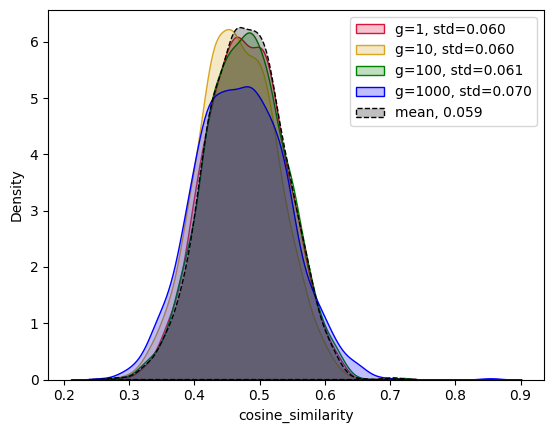

In [632]:
# genetic results distribution for book similarities using different methods
colors = ['crimson', 'goldenrod', 'green', 'blue']
for i, g in enumerate([1, 10, 100, 1000]):
    df_results = genetic_pairing(df, 'The Lord of the Rings', 'Hamlet', 'embed1', method='genetic', granularity=g, N=3194)
    sns.kdeplot(data=df_results, x='cosine_similarity', fill=True, label=f'{g=}, std={np.std(df_results['cosine_similarity']):.3f}', color=colors[i])
# mean result distribution
df_results = genetic_pairing(df, 'The Lord of the Rings', 'Hamlet', 'embed1', method='mean', granularity=g, N=3194)
sns.kdeplot(data=df_results, x='cosine_similarity', fill=True, label=f'mean, {np.std(df_results['cosine_similarity']):.3f}', color='black', linestyle='--')

plt.legend()
plt.show()

* Run over several iterations, the mean method is constant (as expected) but the variability of the genetic methods varies widely
* it appears from inspection that the standard deviation of the similarities tends to be lower with higher grain, but it varies quite a bit so not sure if any conclusions can be drawn there without more rigorous treatment
* Also, how much impact does this have on the ordering of the babies?  We can measure this using jaccard similarity for the top N results

In [662]:
# Showed and discussed with Librarian
# Note: Maturity rating needed - augmentation with another model / toxicity type output (Clan of the Cave Bear is not a kids book!)
# given kid and one parent, who was the other parent? "Who's my daddy"
# Subject headings from worldcat? best / most comprehensive - or library of congress LCSH